In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from sklearn.neighbors import LocalOutlierFactor

In [58]:
df = pd.read_pickle('D:\Projects\Solar Forcasting\Processed Data\Pickle files\sorted_df.pkl')
hourly_df = pd.read_pickle('D:\Projects\Solar Forcasting\Processed Data\Pickle files\hourly_df.pkl')
daily_df = pd.read_pickle('D:\Projects\Solar Forcasting\Processed Data\Pickle files\daily_df.pkl')
monthly_df = pd.read_pickle('D:\Projects\Solar Forcasting\Processed Data\Pickle files\monthly_df.pkl')
yearly_df = pd.read_pickle('D:\Projects\Solar Forcasting\Processed Data\Pickle files\yearly_df.pkl')

In [59]:
# Remove 'DHI' and 'GHI' columns from the 'df' dataframe
df = df.drop(columns=['DHI', 'GHI'])

# Remove 'DHI' and 'GHI' columns from the 'hourly_df' dataframe
hourly_df = hourly_df.drop(columns=['DHI', 'GHI'])

# Remove 'DHI' and 'GHI' columns from the 'daily_df' dataframe
daily_df = daily_df.drop(columns=['DHI', 'GHI'])

# Remove 'DHI' and 'GHI' columns from the 'monthly_df' dataframe
monthly_df = monthly_df.drop(columns=['DHI', 'GHI'])

# Remove 'DHI' and 'GHI' columns from the 'yearly_df' dataframe
yearly_df = yearly_df.drop(columns=['DHI', 'GHI'])

In [60]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 5)
plt.rcParams['figure.dpi'] = 100

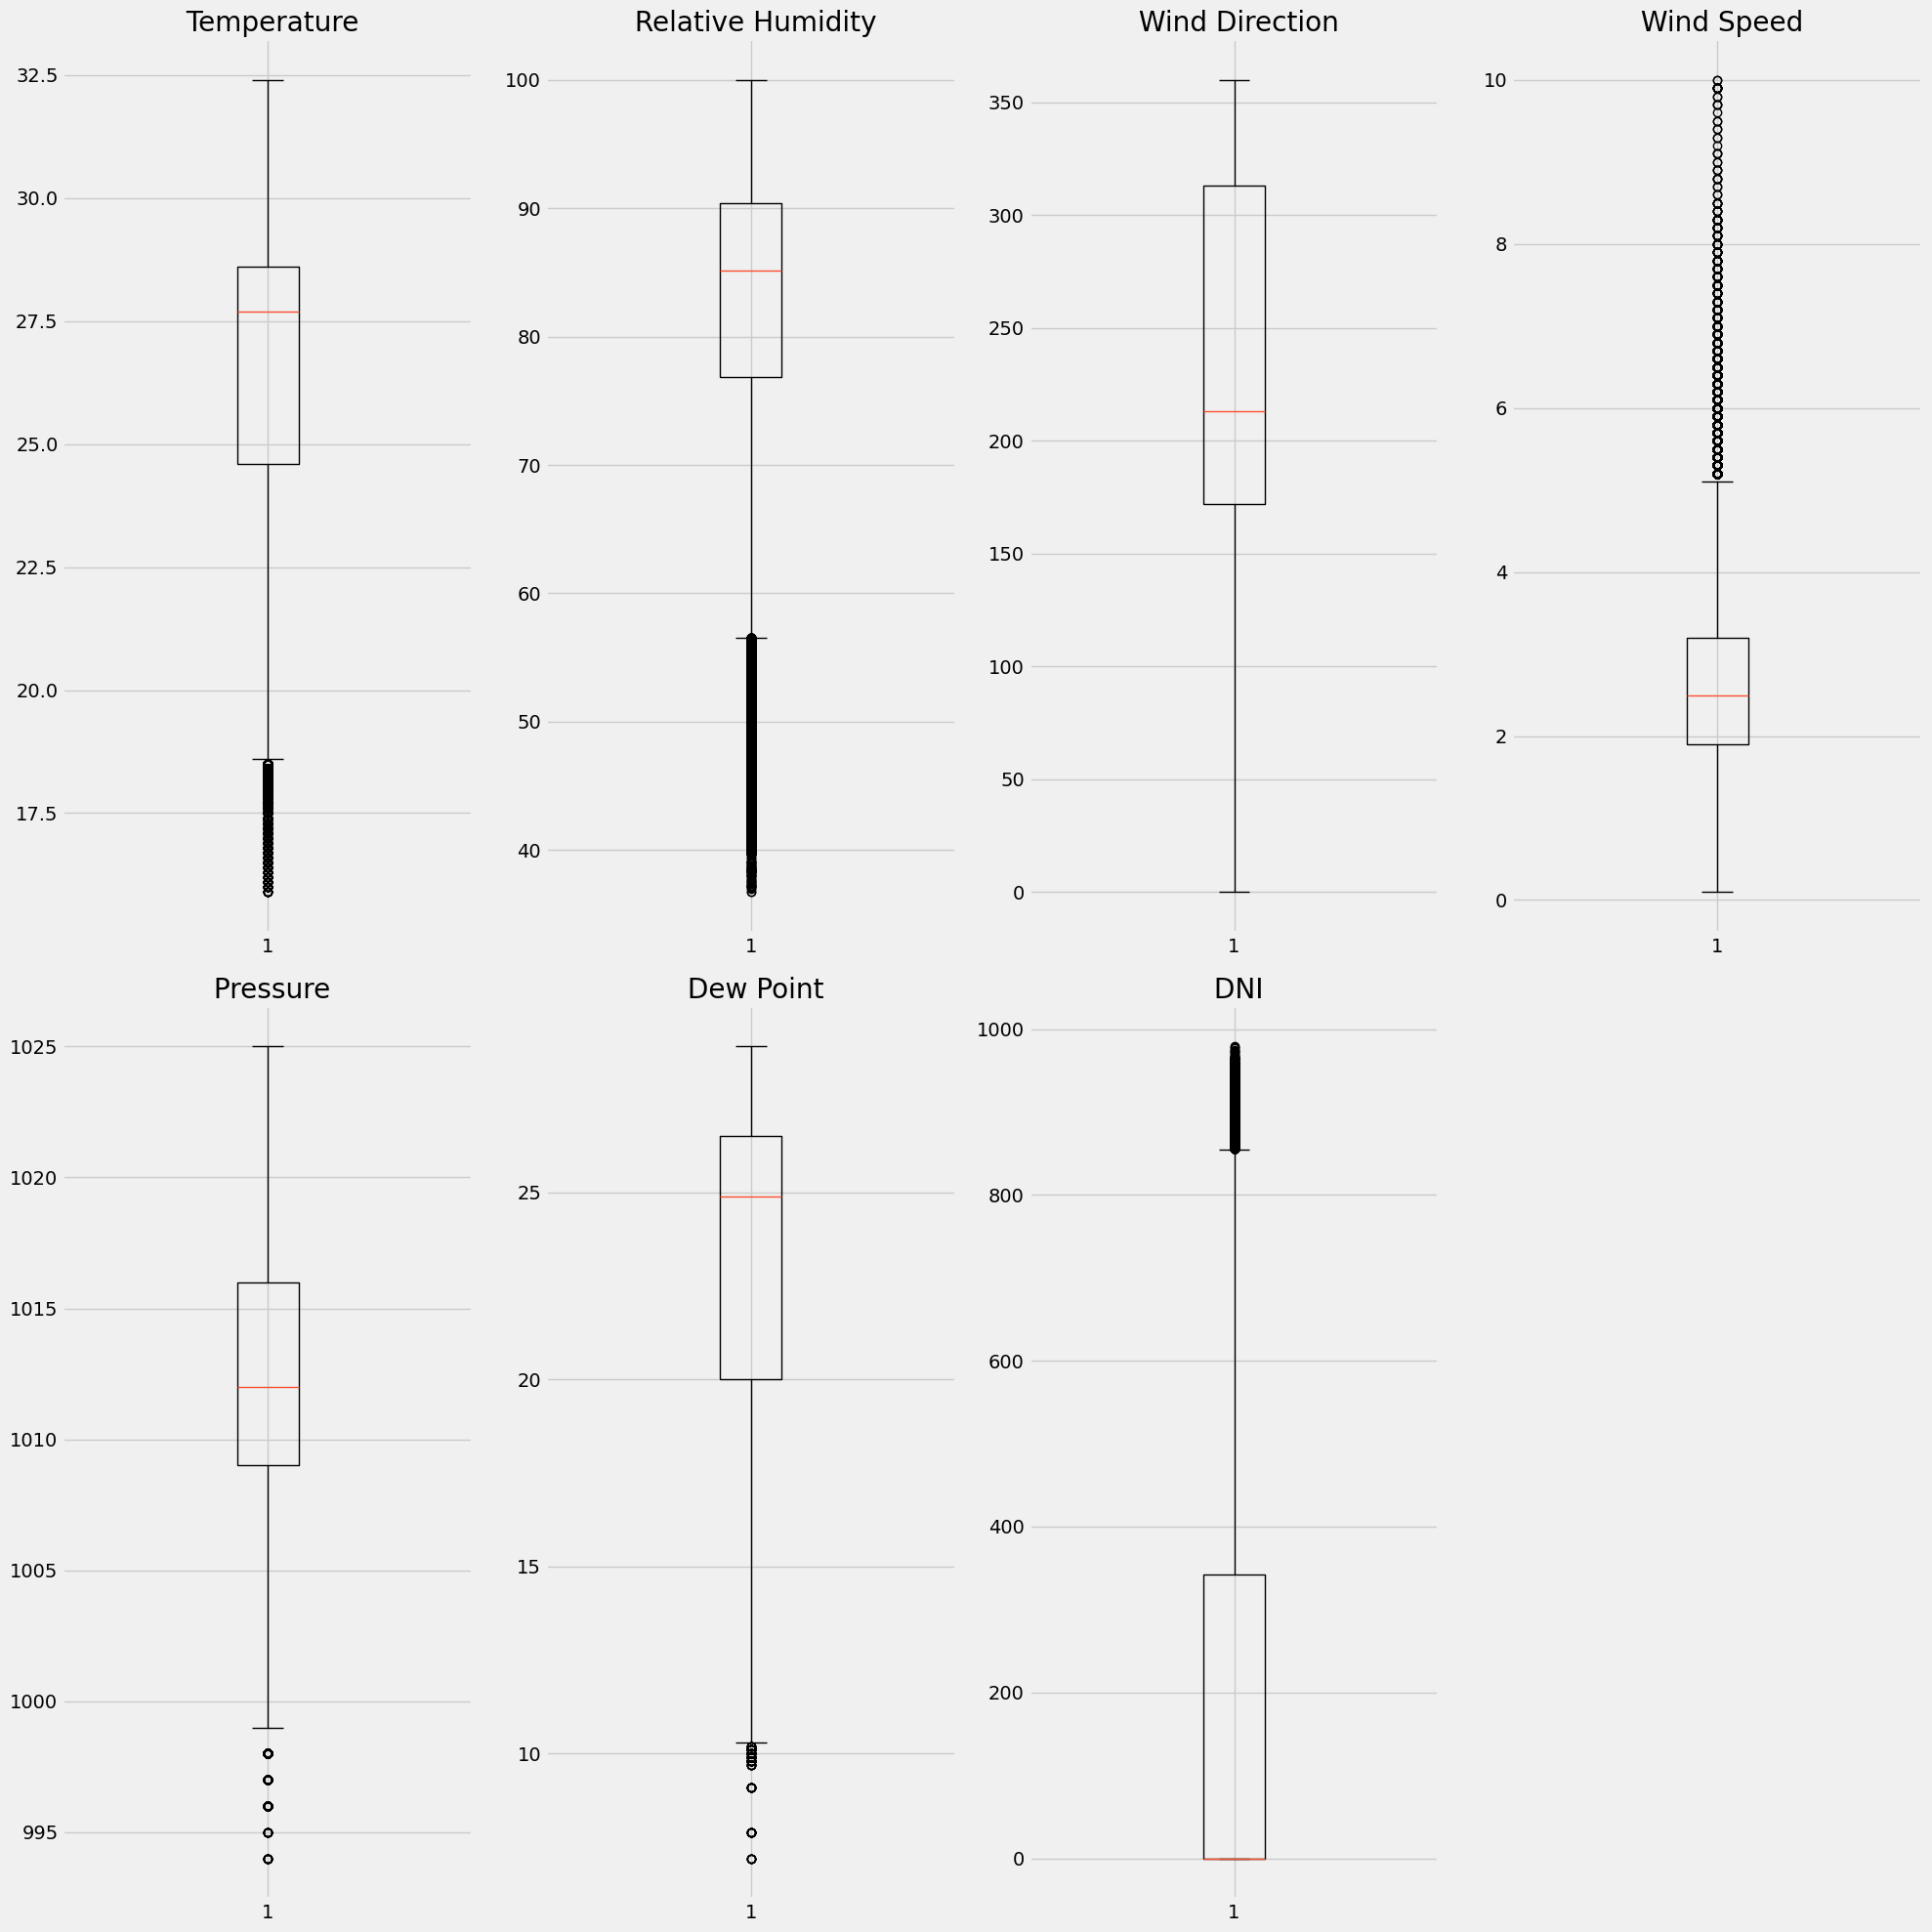

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
columns_to_plot = ['Temperature', 'Relative Humidity', 'Wind Direction', 'Wind Speed', 'Pressure', 'Dew Point', 'DNI']

plt.figure(figsize=(20, 20))

# Create boxplots for each column
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 4, i)  # Create a subplot for each column
    plt.boxplot(df[column])
    plt.title(f' {column}')


plt.tight_layout()  # Adjust subplot layout for better spacing
plt.show()


In [62]:
def plot_binary_outliers(dataset, col, outlier_col, reset_index):
    """ Plot outliers in case of a binary outlier score. Here, the col specifies the real data
    column and outlier_col the columns with a binary value (outlier or not).

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): Column that you want to plot
        outlier_col (string): Outlier column marked with true/false
        reset_index (bool): whether to reset the index for plotting
    """

   
    dataset = dataset.dropna(axis=0, subset=[col, outlier_col])
    dataset[outlier_col] = dataset[outlier_col].astype("bool")

    if reset_index:
        dataset = dataset.reset_index()

    fig, ax = plt.subplots()

    plt.xlabel("samples")
    plt.ylabel("value")

    # Plot non outliers in default color
    ax.plot(
        dataset.index[~dataset[outlier_col]],
        dataset[col][~dataset[outlier_col]],
        "+",
        )
    # Plot data points that are outliers in red
    ax.plot(
        dataset.index[dataset[outlier_col]],
        dataset[col][dataset[outlier_col]],
        "r+",
    )

    plt.legend(
        ["outlier " + col, "no outlier " + col],
        loc="upper center",
        ncol=2,
        fancybox=True,
        shadow=True,
    )
    plt.show()

In [63]:
def mark_outliers_iqr(dataset, col):
    """Function to mark values as outliers using the IQR method.

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column 
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()

    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    dataset[col + "_outlier"] = (dataset[col] < lower_bound) | (
        dataset[col] > upper_bound
    )

    return dataset

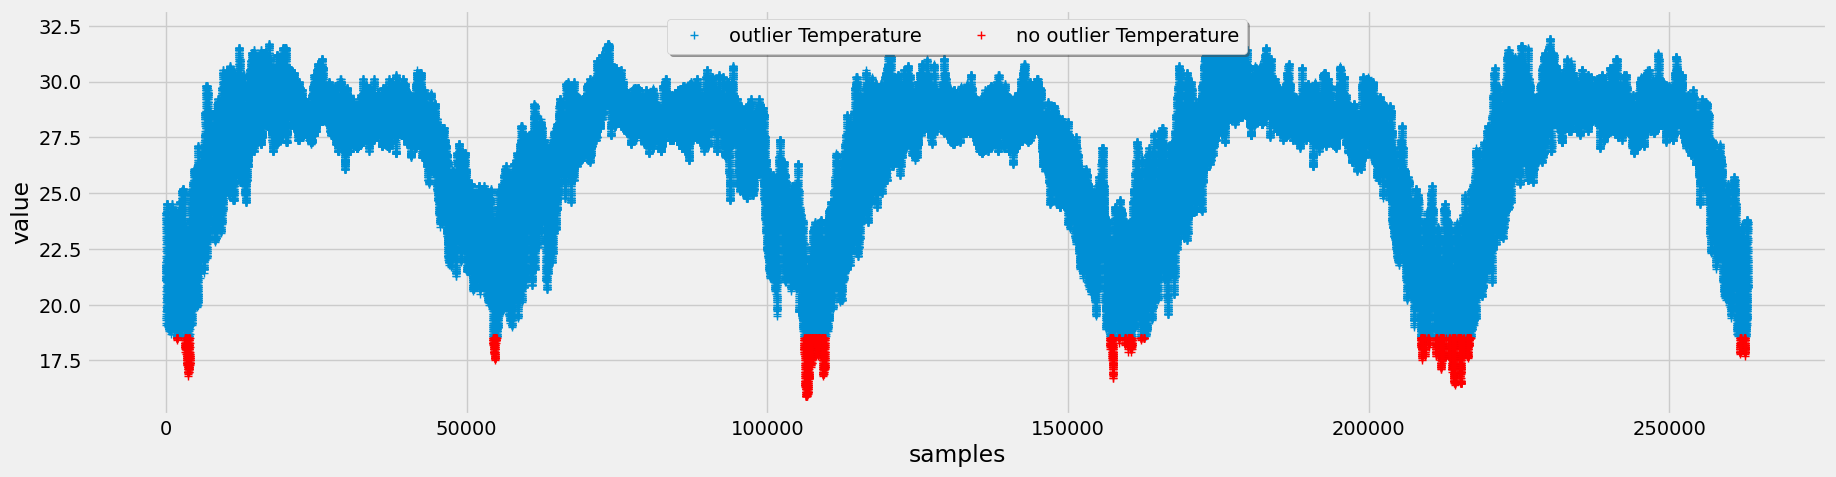

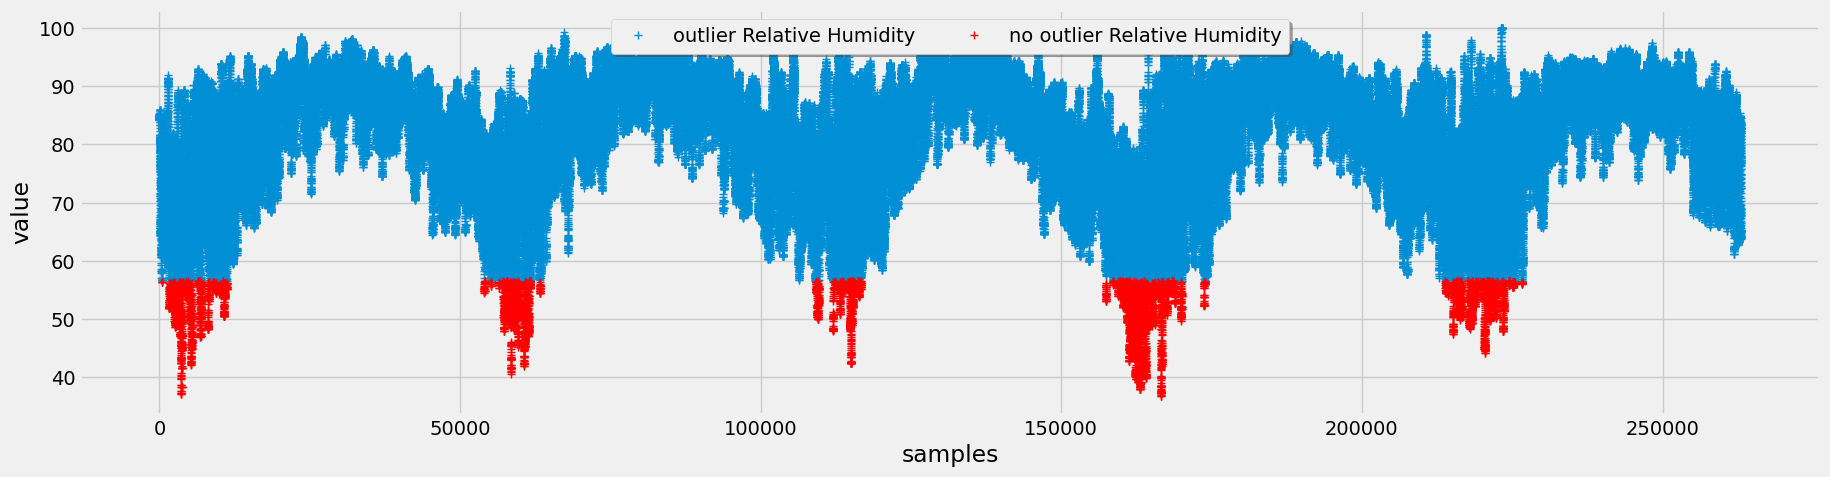

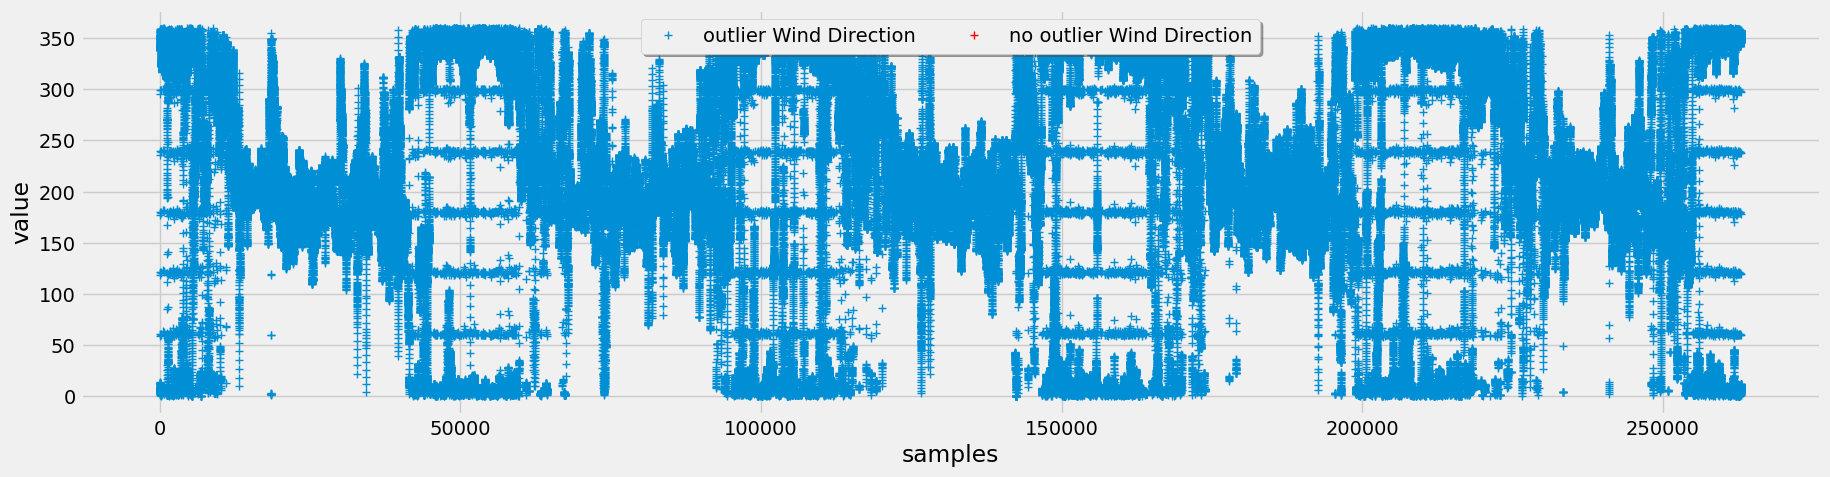

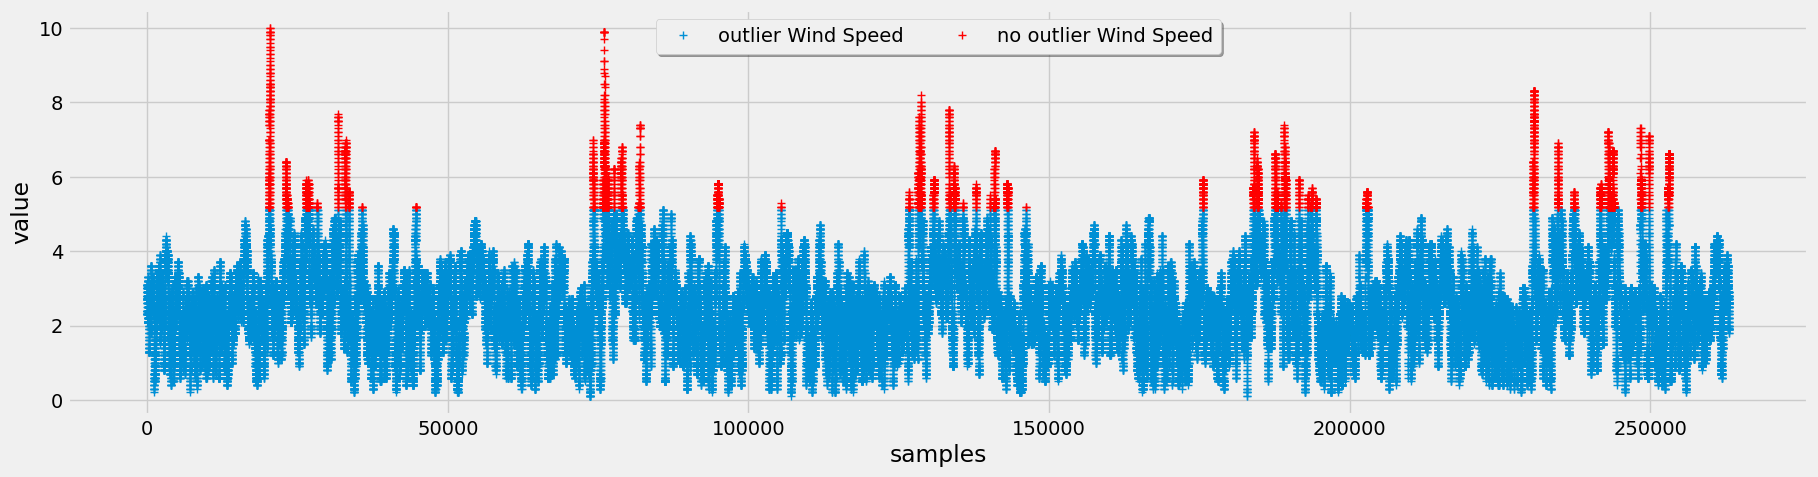

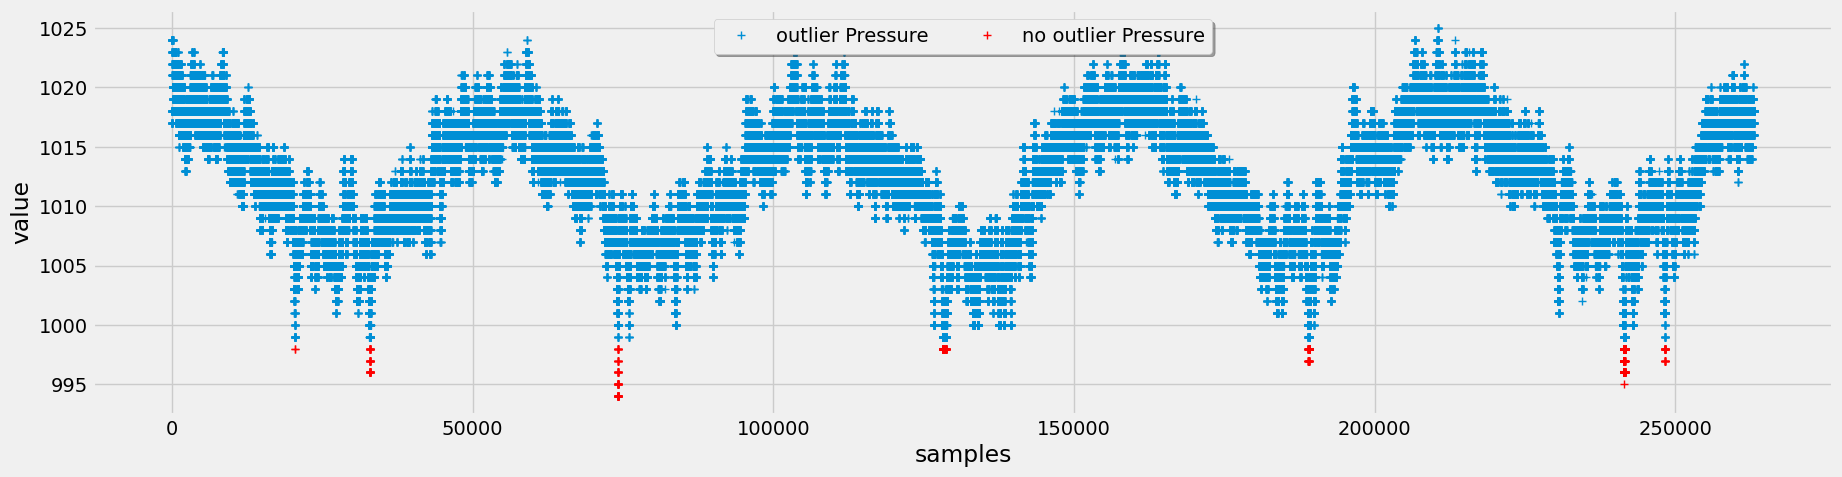

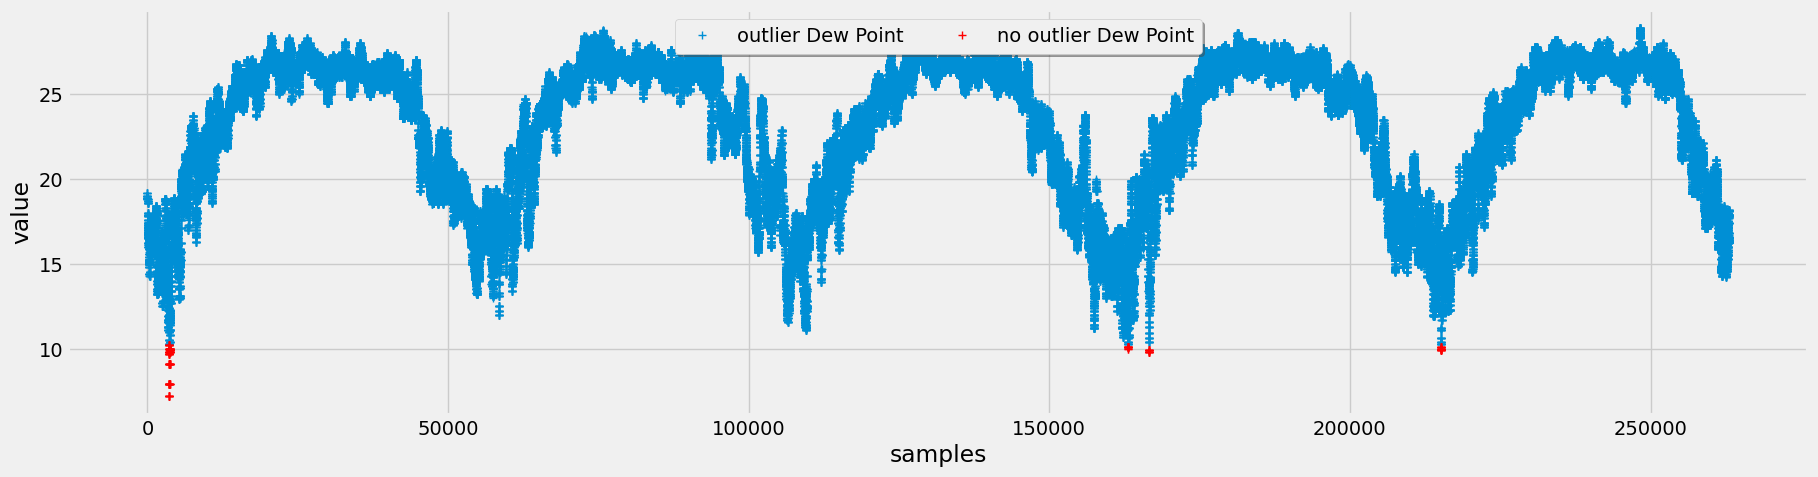

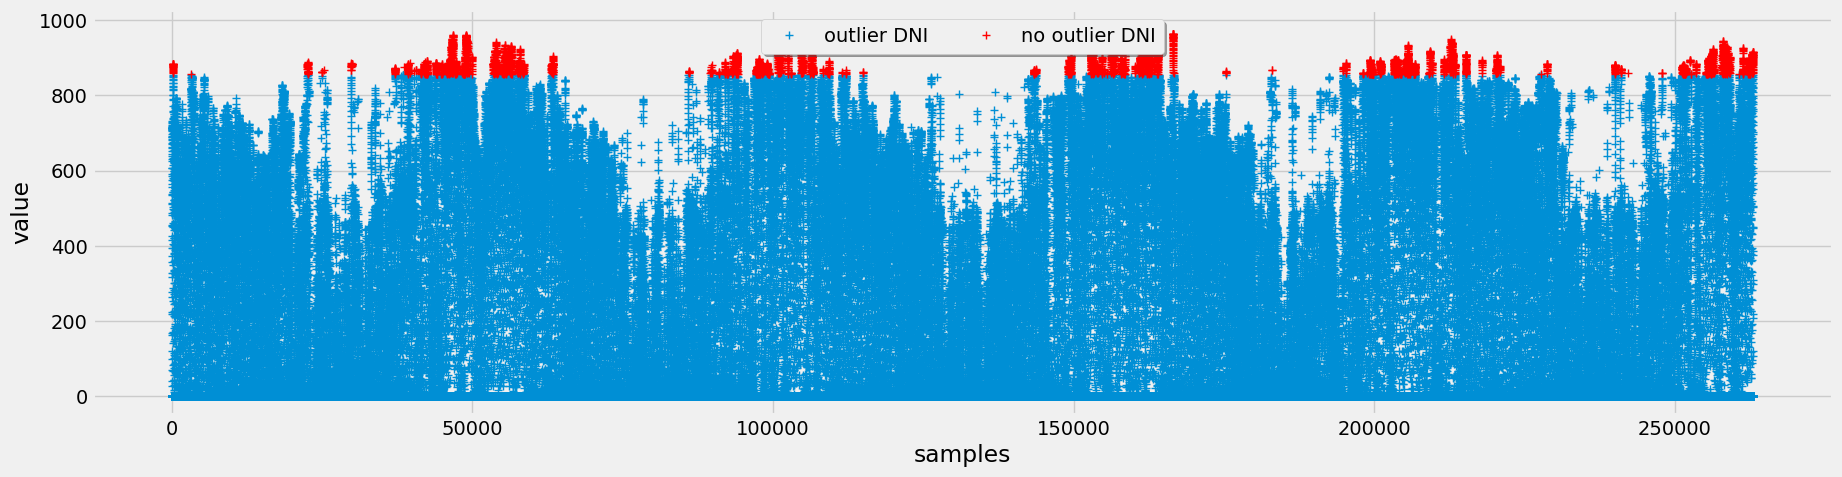

In [64]:
columns =  ['Temperature', 'Relative Humidity', 'Wind Direction', 'Wind Speed', 'Pressure', 'Dew Point', 'DNI']
for col in columns:
    df_without_outliers_iqr = mark_outliers_iqr(df, col)
    plot_binary_outliers(df_without_outliers_iqr, col, col + "_outlier", reset_index=True)

In [65]:
def mark_outliers_chauvenet(dataset, col, C=2):
    """Finds outliers in the specified column of datatable and adds a binary column with
    the same name extended with '_outlier' that expresses the result per data point.
    

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        C (int, optional): Degree of certainty for the identification of outliers given the assumption 
                           of a normal distribution, typicaly between 1 - 10. Defaults to 2.

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column 
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()
    # Compute the mean and standard deviation.
    mean = dataset[col].mean()
    std = dataset[col].std()
    N = len(dataset.index)
    criterion = 1.0 / (C * N)

    # Consider the deviation for the data points.
    deviation = abs(dataset[col] - mean) / std

    # Express the upper and lower bounds.
    low = -deviation / math.sqrt(C)
    high = deviation / math.sqrt(C)
    prob = []
    mask = []
    # Pass all rows in the dataset.
    for i in range(0, len(dataset.index)):
        # Determine the probability of observing the point
        prob.append(
            1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
        )
        # And mark as an outlier when the probability is below our criterion.
        mask.append(prob[i] < criterion)
    dataset[col + "_outlier"] = mask
    return dataset

C:\Users\user\AppData\Local\Temp\ipykernel_29644\298992158.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


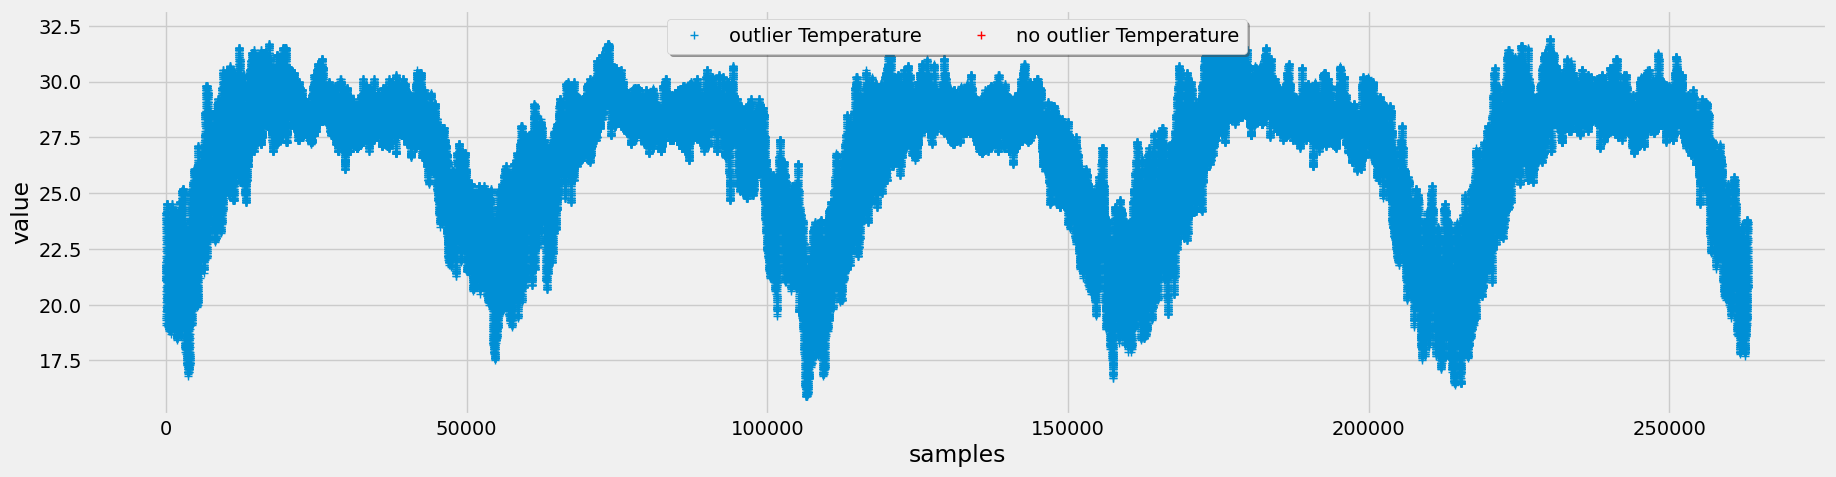

C:\Users\user\AppData\Local\Temp\ipykernel_29644\298992158.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


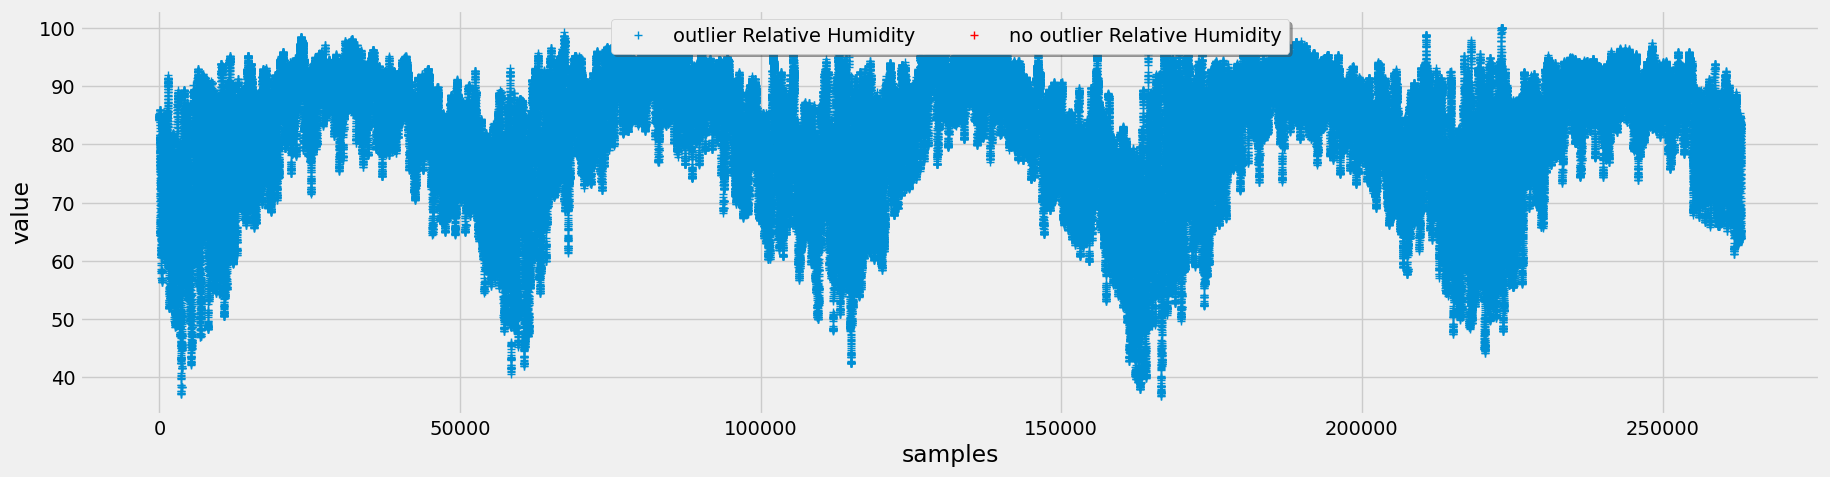

C:\Users\user\AppData\Local\Temp\ipykernel_29644\298992158.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


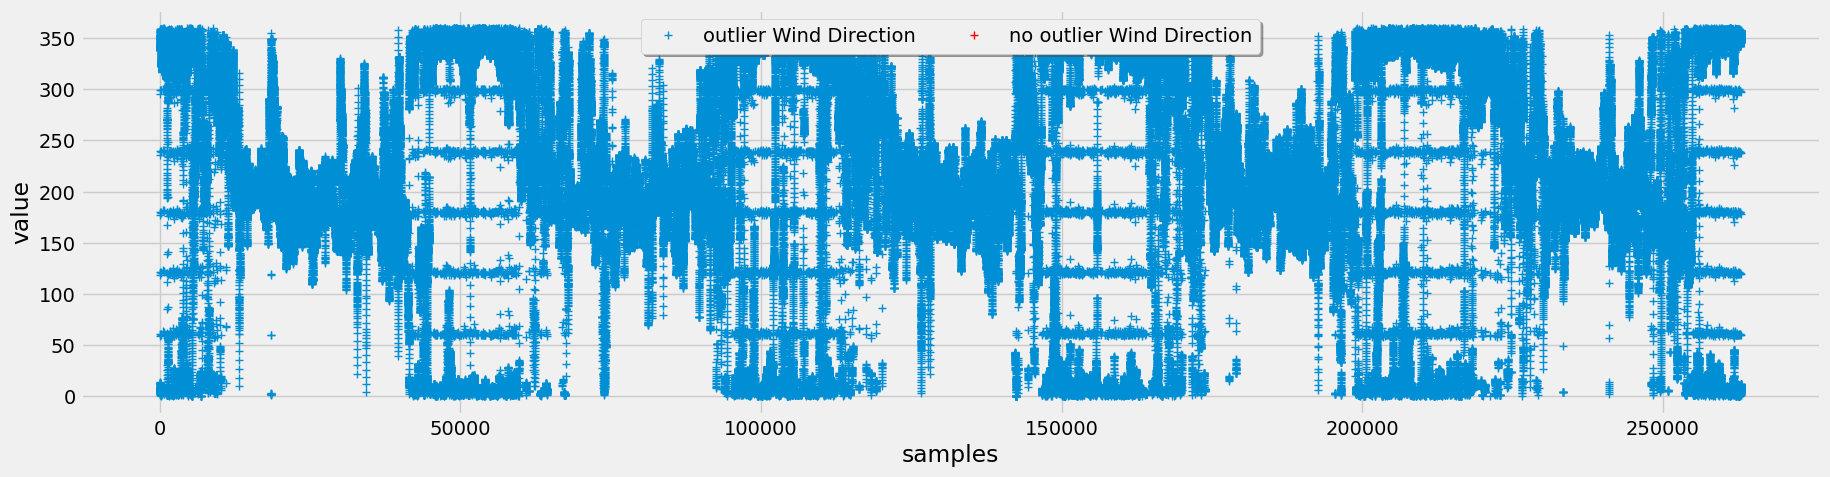

C:\Users\user\AppData\Local\Temp\ipykernel_29644\298992158.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


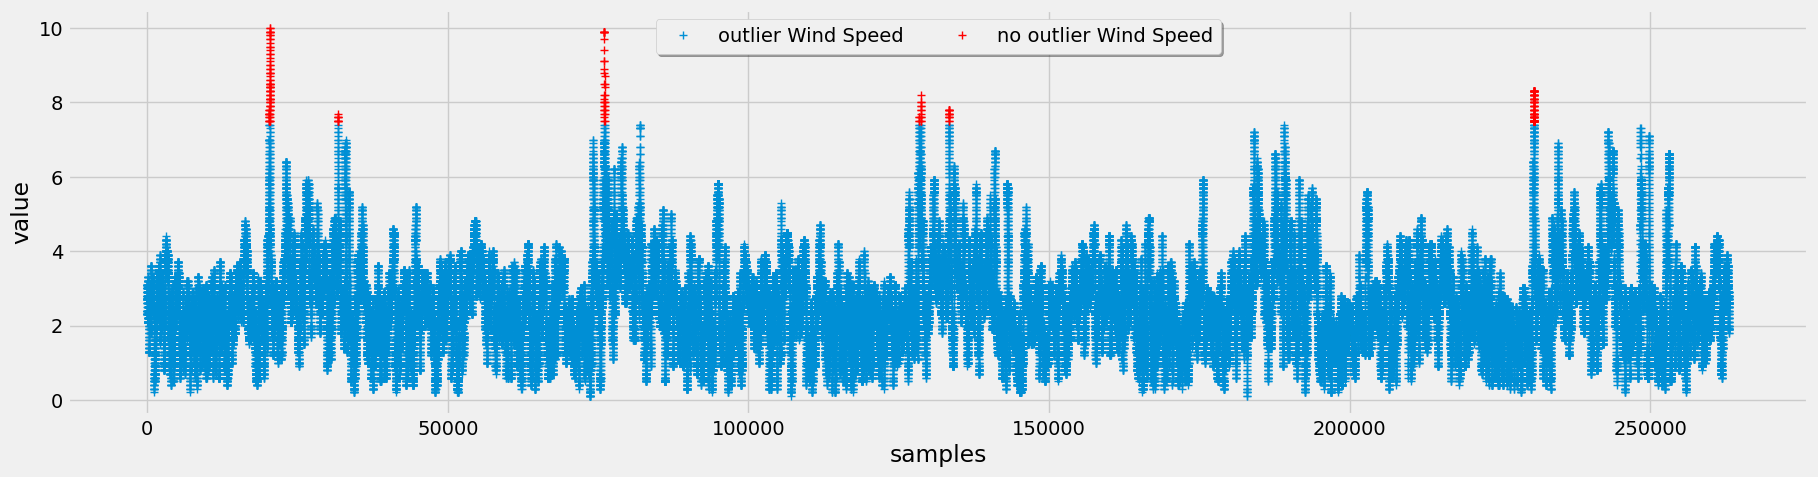

C:\Users\user\AppData\Local\Temp\ipykernel_29644\298992158.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


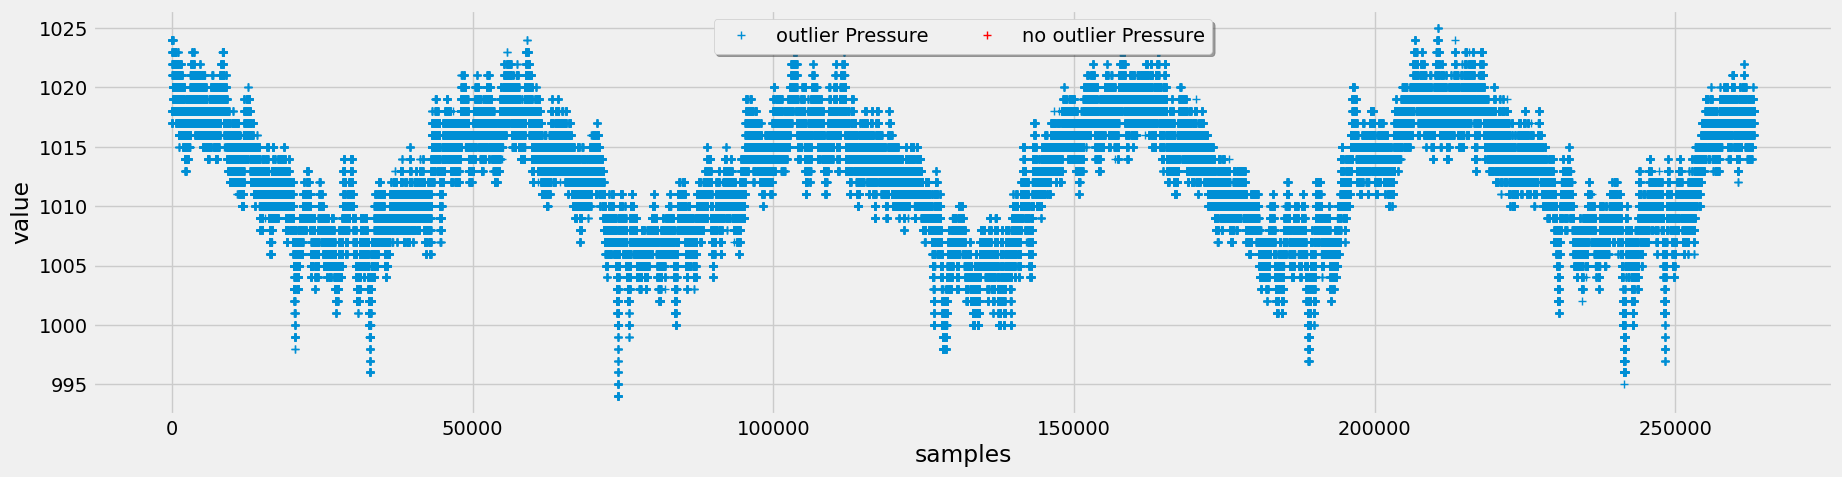

C:\Users\user\AppData\Local\Temp\ipykernel_29644\298992158.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


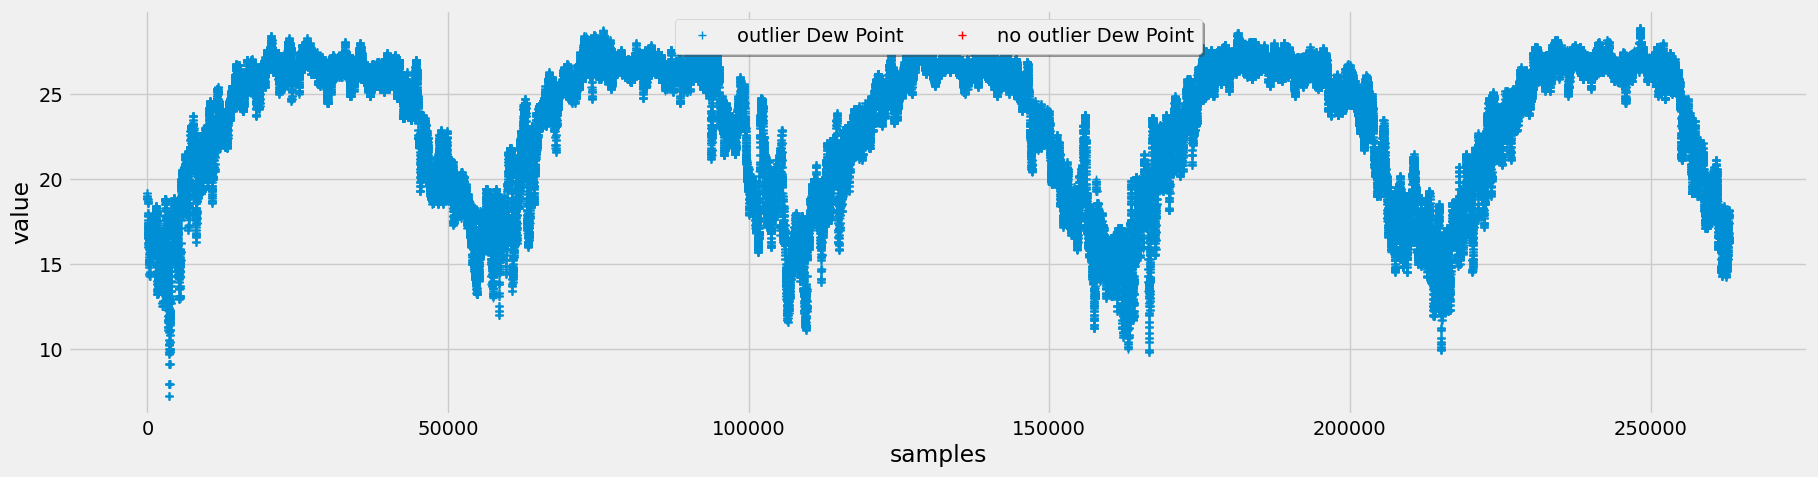

C:\Users\user\AppData\Local\Temp\ipykernel_29644\298992158.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


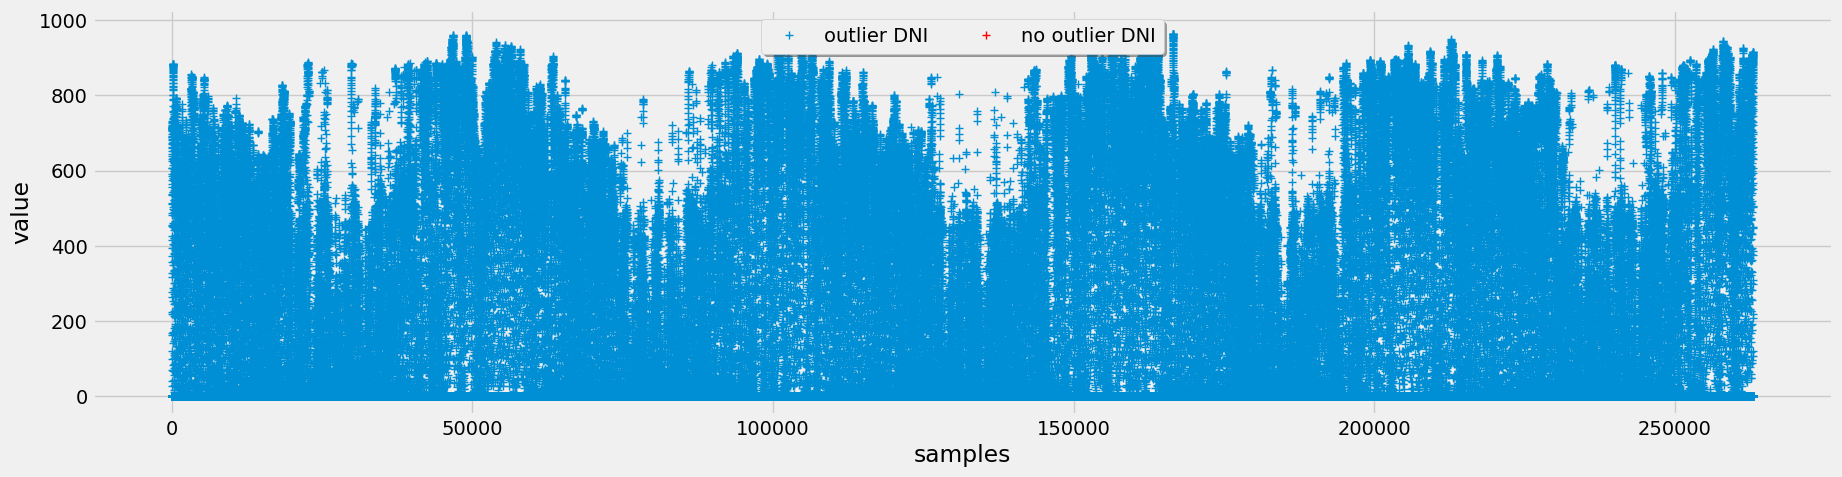

In [66]:

for col in columns:
    df_without_outliers_chv = mark_outliers_chauvenet(df, col)
    plot_binary_outliers(df_without_outliers_chv, col, col + "_outlier", reset_index=True)

In [67]:
def mark_outliers_lof(dataset, columns, n=20):
    """Mark values as outliers using LOF

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        n (int, optional): n_neighbors. Defaults to 20.
    
    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """
    
    dataset = dataset.copy()

    lof = LocalOutlierFactor(n_neighbors=n)
    data = dataset[columns]
    outliers = lof.fit_predict(data)
    X_scores = lof.negative_outlier_factor_

    dataset["outlier_lof"] = outliers == -1
    return dataset, outliers, X_scores

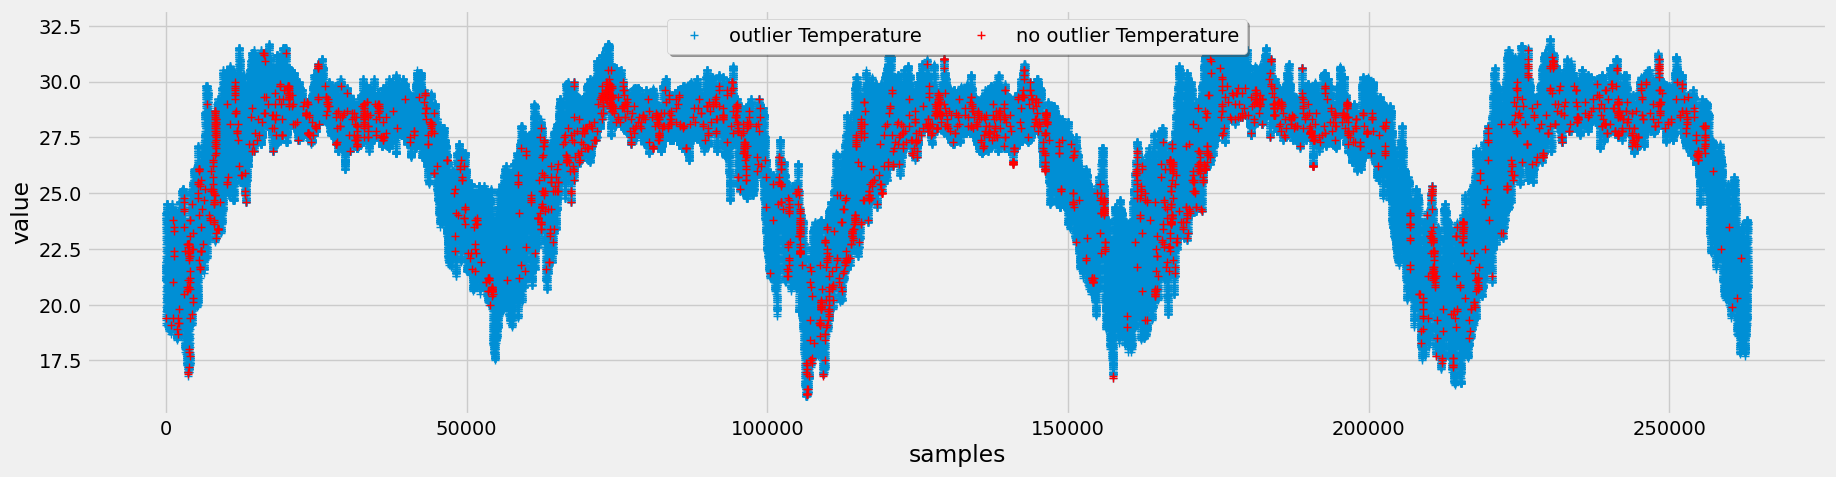

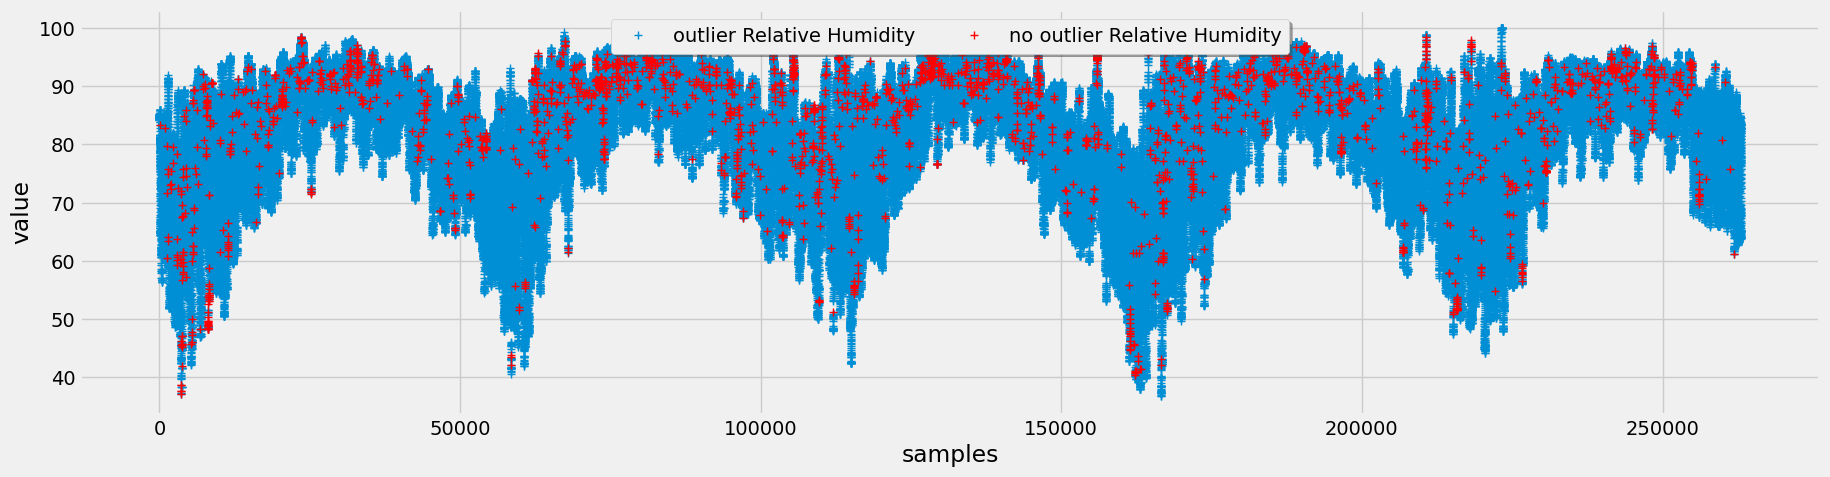

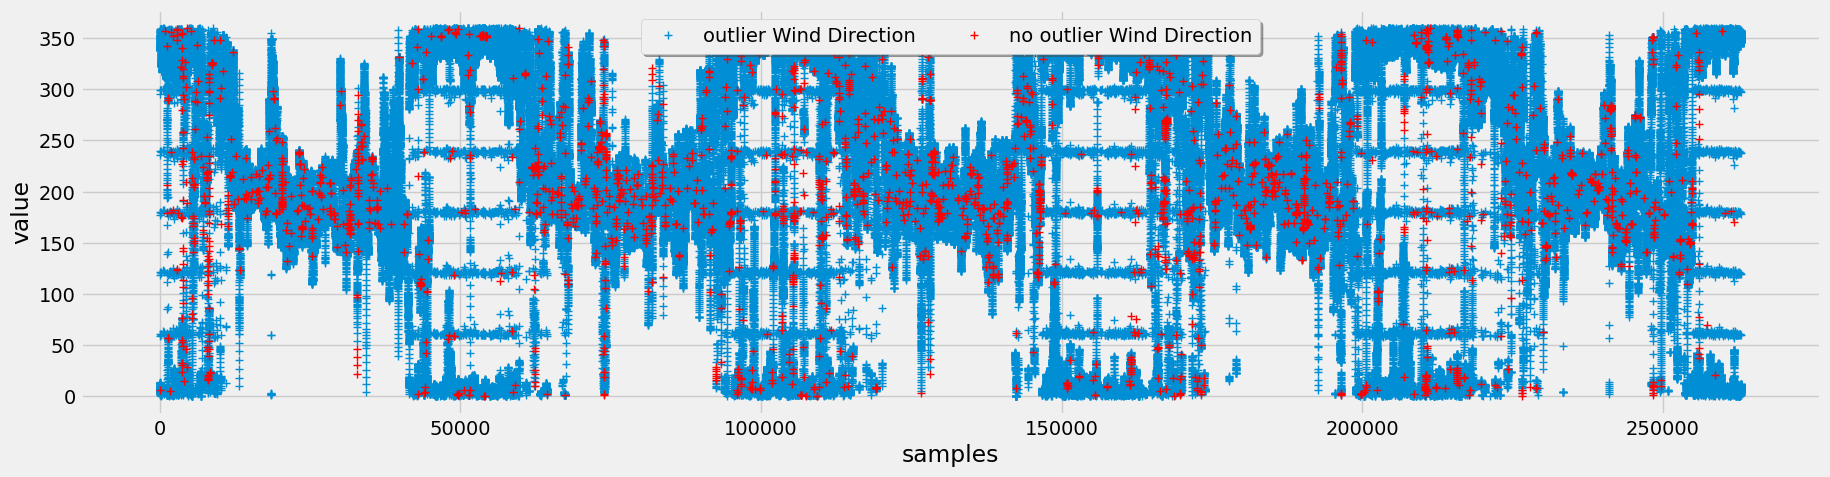

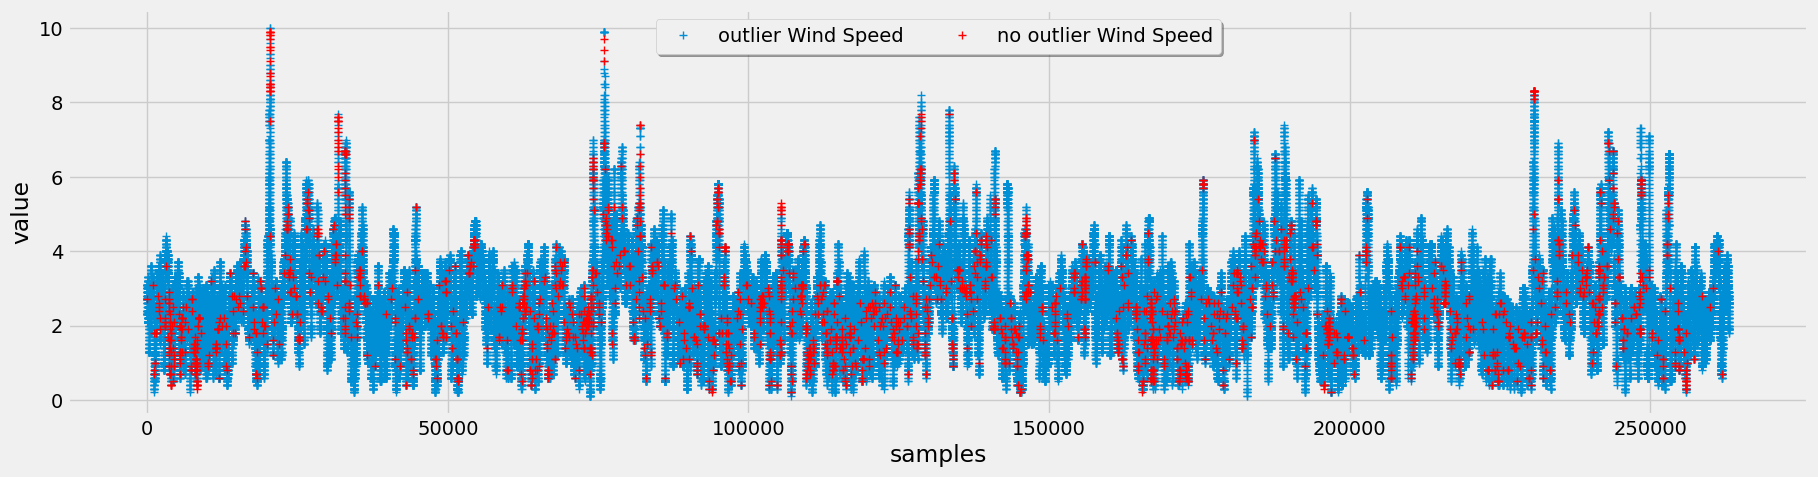

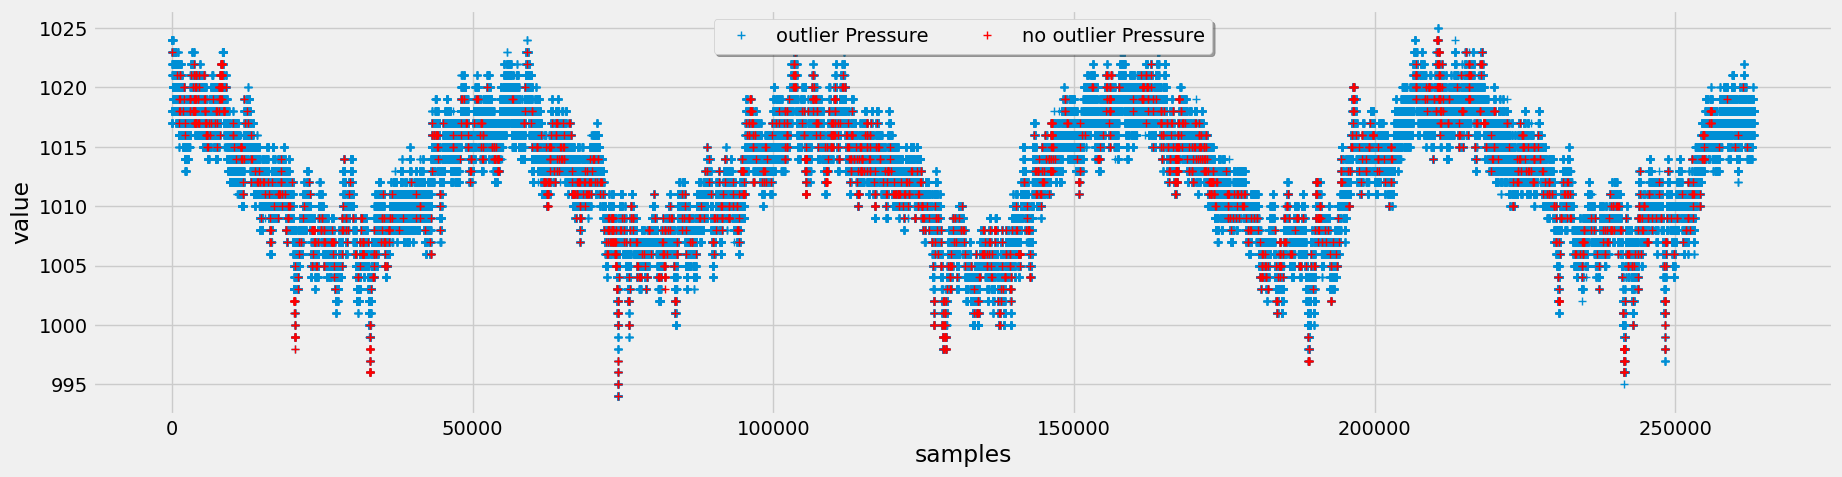

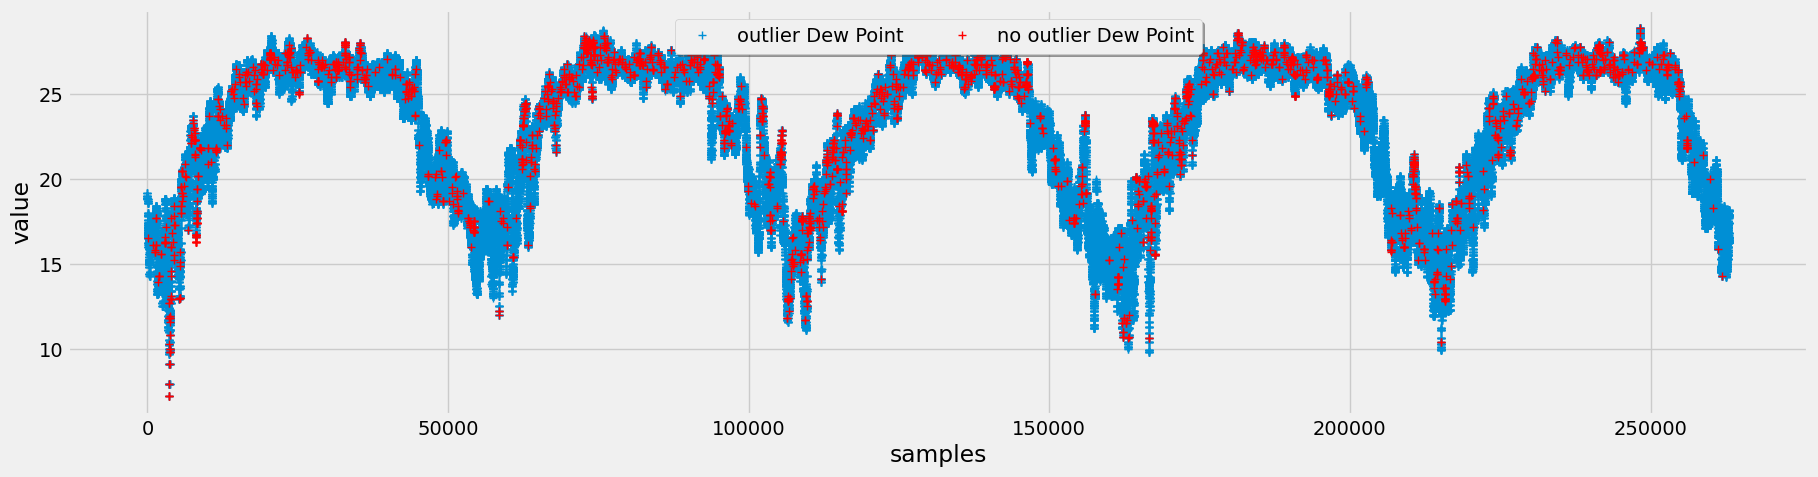

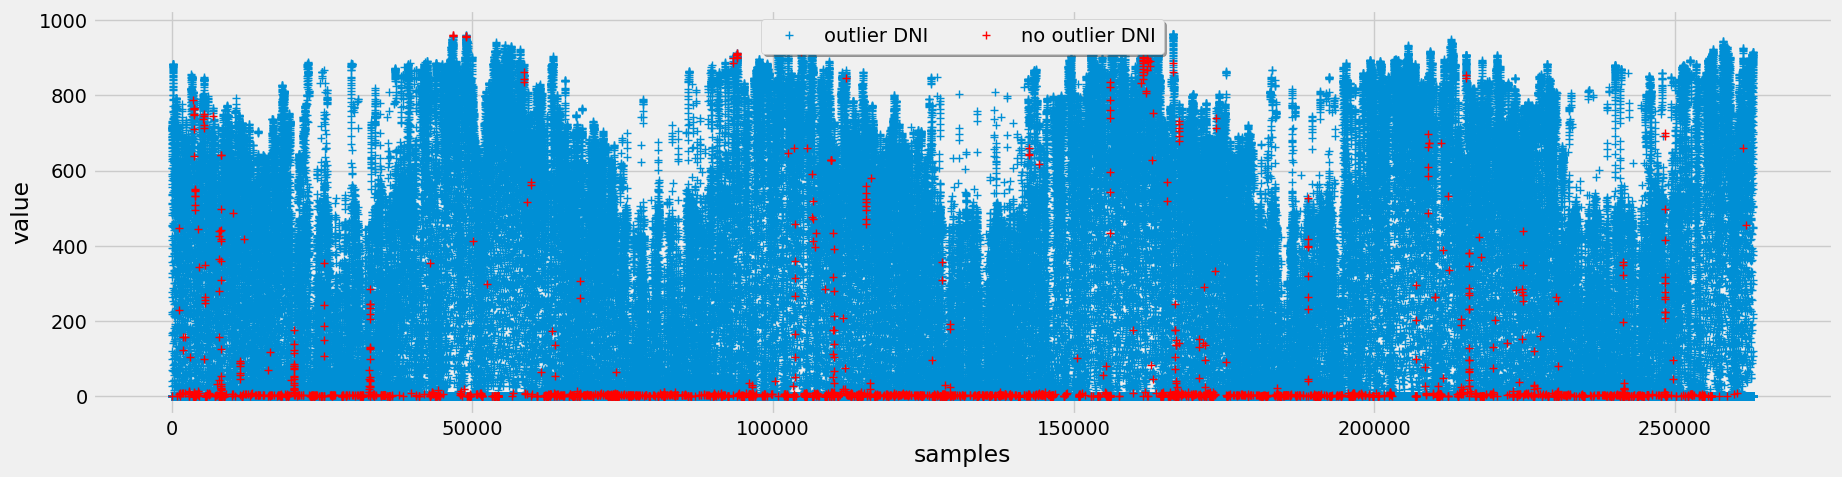

In [68]:
df_with_outliers, outliers, X_score = mark_outliers_lof(df, columns, n=20)
for col in columns:
    plot_binary_outliers(df_with_outliers, col, "outlier_lof", reset_index=True)

In [69]:
hourly_df = pd.read_pickle('D:\Projects\Solar Forcasting\Processed Data\Pickle files\hourly_df.pkl')
daily_df = pd.read_pickle('D:\Projects\Solar Forcasting\Processed Data\Pickle files\daily_df.pkl')
monthly_df = pd.read_pickle('D:\Projects\Solar Forcasting\Processed Data\Pickle files\monthly_df.pkl')
yearly_df = pd.read_pickle('D:\Projects\Solar Forcasting\Processed Data\Pickle files\yearly_df.pkl')


In [70]:
df_without_outliers_chv

Year  Month  Day  Hour  Minute  Temperature  DNI  \
datetime                                                                
2016-01-01 00:00:00  2016      1    1     0       0         21.9    0   
2016-01-01 00:10:00  2016      1    1     0      10         21.9    0   
2016-01-01 00:20:00  2016      1    1     0      20         21.8    0   
2016-01-01 00:30:00  2016      1    1     0      30         21.8    0   
2016-01-01 00:40:00  2016      1    1     0      40         21.8    0   
...                   ...    ...  ...   ...     ...          ...  ...   
2020-12-31 23:10:00  2020     12   31    23      10         20.8    0   
2020-12-31 23:20:00  2020     12   31    23      20         20.8    0   
2020-12-31 23:30:00  2020     12   31    23      30         20.8    0   
2020-12-31 23:40:00  2020     12   31    23      40         20.8    0   
2020-12-31 23:50:00  2020     12   31    23      50         20.8    0   

                     Relative Humidity  Wind Direction  Wind Speed  Pressure  \
datetime                                                                       
2016-01-01 00:00:00              84.47             355         2.6      1018   
2016-01-01 00:10:00              84.47             356         2.7      1018   
2016-01-01 00:20:00              84.98             356         2.7      1018   
2016-01-01 00:30:00              84.98             357         2.7      1018   
2016-01-01 00:40:00              84.30             357         2.7      1018   
...                                ...             ...         ...       ...   
2020-12-31 23:10:00              83.35             356         2.8      1018   
2020-12-31 23:20:00              83.35             357         2.9      1018   
2020-12-31 23:30:00              83.35             357         2.9      1018   
2020-12-31 23:40:00              82.64             357         2.9      1017   
2020-12-31 23:50:00              82.64             358         2.9      1017   

                     Dew Point  DNI_outlier  
datetime                                     
2016-01-01 00:00:00       19.2        False  
2016-01-01 00:10:00       19.2        False  
2016-01-01 00:20:00       19.2        False  
2016-01-01 00:30:00       19.2        False  
2016-01-01 00:40:00       19.0        False  
...                        ...          ...  
2020-12-31 23:10:00       17.9        False  
2020-12-31 23:20:00       17.9        False  
2020-12-31 23:30:00       17.9        False  
2020-12-31 23:40:00       17.7        False  
2020-12-31 23:50:00       17.7        False  

[263088 rows x 13 columns]

In [71]:
df_with_outlier_labels_iqr = df.copy()

# Loop through each sensor column and replace values with NaN where the corresponding outlier column is True
for column in columns:
    df_with_outlier_labels_iqr = mark_outliers_iqr(df_with_outlier_labels_iqr, column)
    df_with_outlier_labels_iqr[column] = df_with_outlier_labels_iqr.apply(lambda row: float('nan') if row[column +'_outlier'] else row[column], axis=1)


In [72]:
df_with_outlier_labels_iqr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 263088 entries, 2016-01-01 00:00:00 to 2020-12-31 23:50:00
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Year                       263088 non-null  int64  
 1   Month                      263088 non-null  int64  
 2   Day                        263088 non-null  int64  
 3   Hour                       263088 non-null  int64  
 4   Minute                     263088 non-null  int64  
 5   Temperature                260145 non-null  float64
 6   DNI                        259396 non-null  float64
 7   Relative Humidity          257370 non-null  float64
 8   Wind Direction             263088 non-null  int64  
 9   Wind Speed                 258037 non-null  float64
 10  Pressure                   262637 non-null  float64
 11  Dew Point                  262968 non-null  float64
 12  Temperature_outlier        263088 non-null  bool   


In [73]:
df_with_outlier_labels_chv = df.copy()

# Loop through each sensor column and replace values with NaN where the corresponding outlier column is True
for column in columns:
    df_with_outlier_labels_chv = mark_outliers_chauvenet(df_with_outlier_labels_chv, column)
    df_with_outlier_labels_chv[column] = df_with_outlier_labels_chv.apply(lambda row: float('nan') if row[column +'_outlier'] else row[column], axis=1)


C:\Users\user\AppData\Local\Temp\ipykernel_29644\298992158.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
C:\Users\user\AppData\Local\Temp\ipykernel_29644\298992158.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
C:\Users\user\AppData\Local\Temp\ipykernel_29644\298992158.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a val

In [74]:
df_with_outlier_labels_chv.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 263088 entries, 2016-01-01 00:00:00 to 2020-12-31 23:50:00
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Year                       263088 non-null  int64  
 1   Month                      263088 non-null  int64  
 2   Day                        263088 non-null  int64  
 3   Hour                       263088 non-null  int64  
 4   Minute                     263088 non-null  int64  
 5   Temperature                263088 non-null  float64
 6   DNI                        263088 non-null  int64  
 7   Relative Humidity          263088 non-null  float64
 8   Wind Direction             263088 non-null  int64  
 9   Wind Speed                 262876 non-null  float64
 10  Pressure                   263088 non-null  int64  
 11  Dew Point                  263088 non-null  float64
 12  Temperature_outlier        263088 non-null  bool   


In [80]:
df_with_outlier_labels_chv = df_with_outlier_labels_chv.drop(columns=['Temperature_outlier', 'Relative Humidity_outlier', 'Wind Direction_outlier', 'Wind Speed_outlier', 'Pressure_outlier', 'Dew Point_outlier', 'DNI_outlier'])

In [82]:
df_with_outlier_labels_chv.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 263088 entries, 2016-01-01 00:00:00 to 2020-12-31 23:50:00
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Year               263088 non-null  int64  
 1   Month              263088 non-null  int64  
 2   Day                263088 non-null  int64  
 3   Hour               263088 non-null  int64  
 4   Minute             263088 non-null  int64  
 5   Temperature        263088 non-null  float64
 6   DNI                263088 non-null  int64  
 7   Relative Humidity  263088 non-null  float64
 8   Wind Direction     263088 non-null  int64  
 9   Wind Speed         262876 non-null  float64
 10  Pressure           263088 non-null  int64  
 11  Dew Point          263088 non-null  float64
dtypes: float64(4), int64(8)
memory usage: 26.1 MB


In [83]:
df_with_outlier_labels_iqr = df_with_outlier_labels_iqr.drop(columns=['Temperature_outlier', 'Relative Humidity_outlier', 'Wind Direction_outlier', 'Wind Speed_outlier', 'Pressure_outlier', 'Dew Point_outlier', 'DNI_outlier'])

In [84]:
df_with_outlier_labels_iqr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 263088 entries, 2016-01-01 00:00:00 to 2020-12-31 23:50:00
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Year               263088 non-null  int64  
 1   Month              263088 non-null  int64  
 2   Day                263088 non-null  int64  
 3   Hour               263088 non-null  int64  
 4   Minute             263088 non-null  int64  
 5   Temperature        260145 non-null  float64
 6   DNI                259396 non-null  float64
 7   Relative Humidity  257370 non-null  float64
 8   Wind Direction     263088 non-null  int64  
 9   Wind Speed         258037 non-null  float64
 10  Pressure           262637 non-null  float64
 11  Dew Point          262968 non-null  float64
dtypes: float64(6), int64(6)
memory usage: 26.1 MB


In [85]:
for col in columns:
    df_with_outlier_labels_iqr[col] = df_with_outlier_labels_iqr[col].interpolate(method='linear', limit_direction='forward')
    df_with_outlier_labels_chv[col] = df_with_outlier_labels_chv[col].interpolate(method='linear', limit_direction='forward')


In [86]:
df_with_outlier_labels_iqr.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 263088 entries, 2016-01-01 00:00:00 to 2020-12-31 23:50:00
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Year               263088 non-null  int64  
 1   Month              263088 non-null  int64  
 2   Day                263088 non-null  int64  
 3   Hour               263088 non-null  int64  
 4   Minute             263088 non-null  int64  
 5   Temperature        263088 non-null  float64
 6   DNI                263088 non-null  float64
 7   Relative Humidity  263088 non-null  float64
 8   Wind Direction     263088 non-null  int64  
 9   Wind Speed         263088 non-null  float64
 10  Pressure           263088 non-null  float64
 11  Dew Point          263088 non-null  float64
dtypes: float64(6), int64(6)
memory usage: 26.1 MB


In [87]:
df_with_outlier_labels_chv.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 263088 entries, 2016-01-01 00:00:00 to 2020-12-31 23:50:00
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Year               263088 non-null  int64  
 1   Month              263088 non-null  int64  
 2   Day                263088 non-null  int64  
 3   Hour               263088 non-null  int64  
 4   Minute             263088 non-null  int64  
 5   Temperature        263088 non-null  float64
 6   DNI                263088 non-null  int64  
 7   Relative Humidity  263088 non-null  float64
 8   Wind Direction     263088 non-null  int64  
 9   Wind Speed         263088 non-null  float64
 10  Pressure           263088 non-null  int64  
 11  Dew Point          263088 non-null  float64
dtypes: float64(4), int64(8)
memory usage: 26.1 MB


In [89]:
df_with_outlier_labels_chv.to_pickle('D:\Projects\Solar Forcasting\Processed Data\Pickle files\df_with_outlier_labels_chv.pkl')
df_with_outlier_labels_iqr.to_pickle('D:\Projects\Solar Forcasting\Processed Data\Pickle files\df_with_outlier_labels_iqr.pkl')
df_with_outlier_labels_iqr.to_csv('D:\Projects\Solar Forcasting\Processed Data\CSV\df_with_outlier_labels_iqr.csv')
df_with_outlier_labels_chv.to_csv('D:\Projects\Solar Forcasting\Processed Data\CSV\df_with_outlier_labels_chv.csv')
